In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')

In [2]:
# df = pd.read_csv('/home/alumnadotarde/Descargas/Bitcoin.csv')
df = pd.read_csv('./bitcoin.csv', delimiter=',')
df.head()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,10.01.2025,"94.724,1","92.540,5","95.760,6","92.310,6","125,42K",+2.36%
1,09.01.2025,"92.539,8","95.066,6","95.323,1","91.241,9","132,78K",-2.66%
2,08.01.2025,"95.066,6","96.938,2","97.266,4","92.716,6","100,36K",-1.92%
3,07.01.2025,"96.929,8","102.247,9","102.678,2","96.201,3","99,77K",-5.20%
4,06.01.2025,"102.248,7","98.373,2","102.474,5","97.932,3","86,73K",+3.97%


In [3]:
df.describe()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
count,4748,4748,4748,4748,4748,4748,4748
unique,4748,4272,4265,4254,4272,4288,1484
top,12.01.2012,"5,1","5,1","5,1","5,1","1,05M","0,00%"
freq,1,26,26,21,21,6,130


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4748 entries, 0 to 4747
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Fecha     4748 non-null   object
 1   Último    4748 non-null   object
 2   Apertura  4748 non-null   object
 3   Máximo    4748 non-null   object
 4   Mínimo    4748 non-null   object
 5   Vol.      4748 non-null   object
 6   % var.    4748 non-null   object
dtypes: object(7)
memory usage: 259.8+ KB


Error cuadrático medio (MSE): 175156.81848438416
Raíz del error cuadrático medio (RMSE): 418.51740523469766


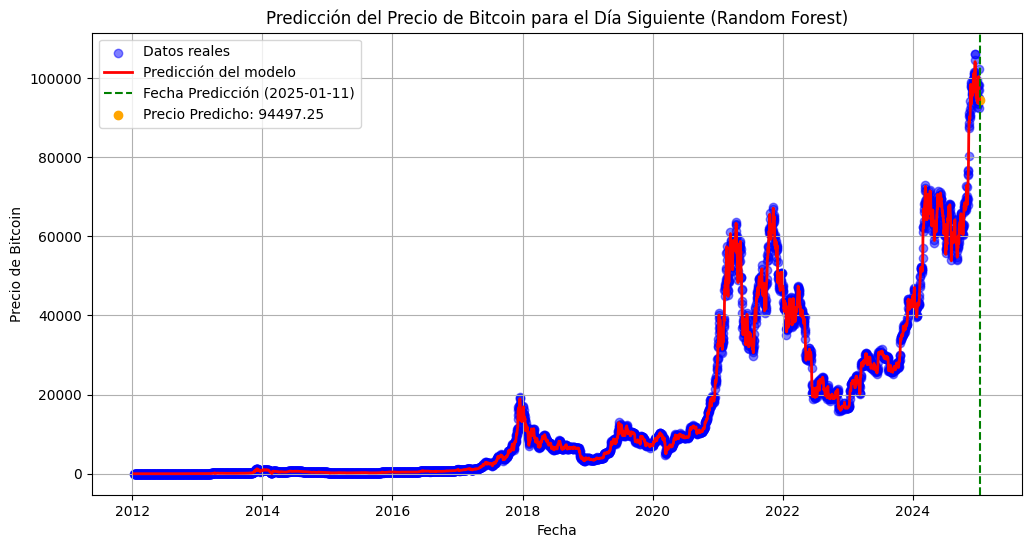

El precio predicho del Bitcoin para el día 2025-01-11 es: 94497.25


In [5]:
# Convertir fecha a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d.%m.%Y', errors='coerce')
df = df.sort_values(by='Fecha')

# Verificar y limpiar las columnas numéricas
for col in ['Último', 'Apertura', 'Máximo', 'Mínimo']:
    if df[col].dtype == 'object':  # Limpiar solo si el tipo es texto
        df[col] = df[col].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Limpiar la columna de Volumen
if df['Vol.'].dtype == 'object':  # Limpiar solo si el tipo es texto
    df['Vol.'] = (
        df['Vol.']
        .str.replace('K', '*1e3', regex=False)  # Miles
        .str.replace('M', '*1e6', regex=False)  # Millones
        .str.replace('B', '*1e9', regex=False)  # Miles de millones
        .str.replace('.', '', regex=False)  # Eliminar puntos
        .str.replace(',', '.', regex=False)  # Reemplazar comas por puntos
        .map(eval)  # Evaluar las expresiones matemáticas
    )

# Convertir fecha a número ordinal
df['Fecha_ordinal'] = df['Fecha'].map(pd.Timestamp.toordinal)

# Crear las variables independientes (características)
X = df[['Fecha_ordinal', 'Apertura', 'Máximo', 'Mínimo', 'Vol.']]

# La variable dependiente será el 'Último' (el precio final del día)
y = df['Último']

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# Crear el modelo Random Forest con hiperparámetros ajustados
model_rf = RandomForestRegressor(
    n_estimators=200,           # Número moderado de árboles para un dataset pequeño
    max_depth=15,               # Profundidad máxima para evitar sobreajuste
    min_samples_split=5,        # Mínimas muestras para dividir un nodo
    min_samples_leaf=2,         # Mínimas muestras en una hoja
    max_features="sqrt",       # Selección de número de variables en cada división
    random_state=44            # Reproducibilidad
)

# Entrenar el modelo
model_rf.fit(X_train, y_train)

# Predecir los precios para el conjunto de prueba
y_pred_rf = model_rf.predict(X_test)

# Evaluar el modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
print(f"Error cuadrático medio (MSE): {mse_rf}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse_rf}")

# Predicción para el siguiente día (última fecha del dataset + 1 día)
proxima_fecha = df['Fecha'].max() + pd.Timedelta(days=1)
proxima_fecha_ordinal = proxima_fecha.toordinal()
entrada_prediccion = pd.DataFrame({
    'Fecha_ordinal': [proxima_fecha_ordinal],
    'Apertura': [df['Apertura'].iloc[-1]],
    'Máximo': [df['Máximo'].iloc[-1]],
    'Mínimo': [df['Mínimo'].iloc[-1]],
    'Vol.': [df['Vol.'].iloc[-1]]
})
precio_predicho_rf = model_rf.predict(entrada_prediccion)[0]

# Graficar resultados
plt.figure(figsize=(12, 6))

# Gráfica de los datos reales
plt.scatter(df['Fecha'], df['Último'], color='blue', label='Datos reales', alpha=0.5)

# Gráfica de las predicciones del modelo sobre los datos históricos
predicciones_historicas_rf = model_rf.predict(X)
plt.plot(df['Fecha'], predicciones_historicas_rf, color='red', label='Predicción del modelo', linewidth=2)

# Punto para la predicción del día siguiente
plt.axvline(x=proxima_fecha, color='green', linestyle='--', label=f'Fecha Predicción ({proxima_fecha.date()})')
plt.scatter(proxima_fecha, precio_predicho_rf, color='orange', label=f'Precio Predicho: {precio_predicho_rf:.2f}')

# Etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Precio de Bitcoin')
plt.title('Predicción del Precio de Bitcoin para el Día Siguiente (Random Forest)')
plt.legend()
plt.grid()
plt.show()

# Mostrar el precio predicho
print(f"El precio predicho del Bitcoin para el día {proxima_fecha.date()} es: {precio_predicho_rf:.2f}")

#196298.28384985376 44 44

In [6]:
print("Última fecha del dataset:", df['Fecha'].max())
print("Fecha de la predicción:", proxima_fecha)

Última fecha del dataset: 2025-01-10 00:00:00
Fecha de la predicción: 2025-01-11 00:00:00


In [7]:
df.tail()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.,Fecha_ordinal
4,2025-01-06,102248.7,98373.2,102474.5,97932.3,86730.0,+3.97%,739257
3,2025-01-07,96929.8,102247.9,102678.2,96201.3,99770.0,-5.20%,739258
2,2025-01-08,95066.6,96938.2,97266.4,92716.6,100360.0,-1.92%,739259
1,2025-01-09,92539.8,95066.6,95323.1,91241.9,132780.0,-2.66%,739260
0,2025-01-10,94724.1,92540.5,95760.6,92310.6,125420.0,+2.36%,739261


## Arriba sin shift(RandomForestRegressor)

## Abajo con shift( y regresion)


Error Cuadrático Medio (MSE): 658261.4004863945


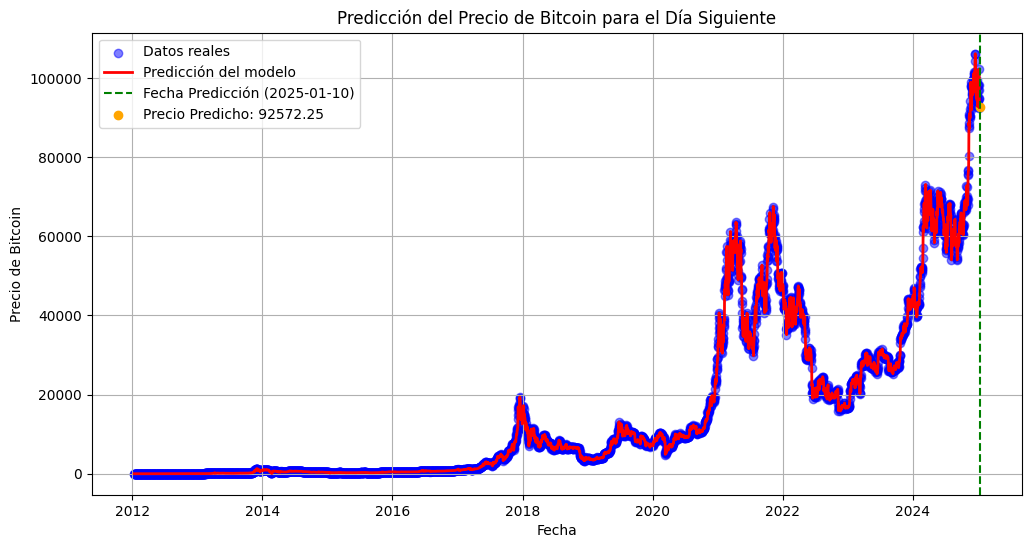

El precio predicho del Bitcoin para el día 2025-01-10 es: 92572.25


In [8]:
# Crear la columna del precio del día siguiente
df['Precio_Mañana'] = df['Último'].shift(-1)

# Eliminar filas con valores NaN
df = df.dropna()

# Crear las variables independientes (características) y dependiente (Precio_Mañana)
X = df[['Fecha_ordinal', 'Último', 'Vol.']]
y = df['Precio_Mañana']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# Entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Predecir los precios para el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el Error Cuadrático Medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Error Cuadrático Medio (MSE): {mse}')

# Predicción para el día siguiente (última fecha del dataset + 1 día)
proxima_fecha = df['Fecha'].max() + pd.Timedelta(days=1)
proxima_fecha_ordinal = proxima_fecha.toordinal()
entrada_prediccion = [[proxima_fecha_ordinal, df['Último'].iloc[-1], df['Vol.'].iloc[-1]]]
precio_predicho = model.predict(entrada_prediccion)[0]



# Graficar resultados
plt.figure(figsize=(12, 6))

# Gráfica de los datos reales
plt.scatter(df['Fecha'], df['Precio_Mañana'], color='blue', label='Datos reales', alpha=0.5)

# Gráfica de las predicciones del modelo sobre los datos históricos
predicciones_historicas = model.predict(X)
plt.plot(df['Fecha'], predicciones_historicas, color='red', label='Predicción del modelo', linewidth=2)

# Punto para la predicción del día siguiente
plt.axvline(x=proxima_fecha, color='green', linestyle='--', label=f'Fecha Predicción ({proxima_fecha.date()})')
plt.scatter(proxima_fecha, precio_predicho, color='orange', label=f'Precio Predicho: {precio_predicho:.2f}')

# Etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Precio de Bitcoin')
plt.title('Predicción del Precio de Bitcoin para el Día Siguiente')
plt.legend()
plt.grid()
plt.show()

# Mostrar el precio predicho
print(f"El precio predicho del Bitcoin para el día {proxima_fecha.date()} es: {precio_predicho:.2f}")

In [9]:
print("Última fecha del dataset:", df['Fecha'].max())
print("Fecha de la predicción:", proxima_fecha)


Última fecha del dataset: 2025-01-09 00:00:00
Fecha de la predicción: 2025-01-10 00:00:00


In [10]:
df.tail()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.,Fecha_ordinal,Precio_Mañana
5,2025-01-05,98347.7,98220.1,98823.1,97300.0,31340.0,+0.13%,739256,102248.7
4,2025-01-06,102248.7,98373.2,102474.5,97932.3,86730.0,+3.97%,739257,96929.8
3,2025-01-07,96929.8,102247.9,102678.2,96201.3,99770.0,-5.20%,739258,95066.6
2,2025-01-08,95066.6,96938.2,97266.4,92716.6,100360.0,-1.92%,739259,92539.8
1,2025-01-09,92539.8,95066.6,95323.1,91241.9,132780.0,-2.66%,739260,94724.1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4747 entries, 4747 to 1
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Fecha          4747 non-null   datetime64[ns]
 1   Último         4747 non-null   float64       
 2   Apertura       4747 non-null   float64       
 3   Máximo         4747 non-null   float64       
 4   Mínimo         4747 non-null   float64       
 5   Vol.           4747 non-null   float64       
 6   % var.         4747 non-null   object        
 7   Fecha_ordinal  4747 non-null   int64         
 8   Precio_Mañana  4747 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 370.9+ KB


In [12]:
# # Crear las variables independientes (Fecha como número ordinal) y dependiente (Precio_Mañana)
# X = df[['Fecha_ordinal']].values
# y = df['Precio_Mañana'].values

# # Dividir los datos en entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Entrenar el modelo de regresión lineal
# model = LinearRegression()
# model.fit(X_train, y_train)

# # Predecir los precios para el conjunto de prueba
# y_pred = model.predict(X_test)

# # Graficar los resultados
# plt.figure(figsize=(12, 6))
# plt.scatter(df['Fecha'], df['Precio_Mañana'], color='blue', label='Datos reales', alpha=0.5)
# plt.plot(df['Fecha'], model.predict(df[['Fecha_ordinal']]), color='red', label='Predicción del modelo', linewidth=2)
# plt.xlabel('Fecha')
# plt.ylabel('Precio de Bitcoin')
# plt.title('Predicción del Precio de Bitcoin para el Día Siguiente')
# plt.legend()
# plt.grid()
# plt.show()